#-------------------------------------------------------------------------------
#--         Federal University of Santa Maria             
#--               Technology Center            
#--            Computer Engineering Course
#--
#-- Author      : Luis Felipe de Deus                           
#--
#-- Created     : 15 May 2020
#-- Update      : 21 May 2020                                                  
#-------------------------------------------------------------------------------
####### JUST A SMALL IMPLEMENTATION OF ARTIFICIAL NEURAL NETWORK
####### USING FEEDFORWARD APPROACH
####### WITH BACKPROPAGATION APPROACH WITHOUT LIBRARIES
####### THE NUMBER OF NEURONS FOR EACH LAYER IS PARAMETRIZABLE
####### THE NUMBER OF HIDDEN LAYERS IS ALSO PARAMETRIZABLE


In [0]:
#Remove the iris Dataset if already has
!rm Iris.csv

rm: cannot remove 'Iris.csv': No such file or directory


In [0]:
#import the libs
import numpy as np
from google.colab import files
import io
import random
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

In [0]:
#Upload has the raw dataset
uploaded = files.upload()

# f is the Iris.csv file
f = io.BytesIO(uploaded['Iris.csv'])

Saving Iris.csv to Iris.csv


In [0]:
f.seek(0)
# lines is a list with strings for each line from Iris
lines = f.readlines()

In [0]:
#Create the tensor for X (input) and Y(Output)
X = np.zeros((len(lines)-1,4)) # 4 Inputs
Y = np.zeros((len(lines)-1,3)) # 3 Outputs (one-hot encoding)

#Create an array with the categorys
cat = np.array(['Iris-setosa','Iris-versicolor','Iris-virginica'])

In [0]:
# For it line, except the zero because is the header
for i, line in enumerate(lines[1:]):
  #Decode
  s = line.decode()[:-1]

  #Split the line
  _,sl,sw,pl,pw,sp = s.split(',')

  #Change data type
  sl = float(sl)
  sw = float(sw)
  pl = float(pl)
  pw = float(pw)
  
  #Stores in X the dataset
  X[i:] = np.array([sl,sw,pl,pw])
  #In Y we have an array with one-hot encoding, where 1 is true and 0 is false
  Y[i:] = (cat == sp).astype('float')
  #e.g. [1.0, 0.0, 0.0]
  

In [0]:
indexes = list(range(150))
random.shuffle(indexes)

#Split the dataset with 140 samples for trainning
T = 140

Xt = np.zeros((T,4))
Yt = np.zeros((T,3))
Xv = np.zeros((150-T,4))
Yv = np.zeros((150-T,3))

for i in range(0,T):
  Xt[i,:] = X[indexes[i],:]
  Yt[i,:] = Y[indexes[i],:]
for i in range(0,150-T):
  Xv[i,:] = X[indexes[T+i],:]
  Yv[i,:] = Y[indexes[T+i],:]


In [0]:
#@brief: Activation function
#@param: s - is tensor to be applyed to sigmoid
#@param: deriv - If True returns the derivative from sigmoid
def sigmoid(s, deriv=False):
    if (deriv == True):
        return s * (1 - s)
    return 1/(1 + np.exp(-s))

In [0]:
#@brief: Implements a Perceptron Neural Network
#@param: input_size - number of neurons on input layer (e.g. 4)
#@param: hidden_layer - a list with the number of neurons on each hidden layer (e.g [4,7])
#@param: output_layer - number of neurons on output layer
class Perceptron:
  def __init__(self, input_size, hidden_layer, output_layer):
    self.ilayer = input_size
    self.hlayer = hidden_layer
    self.olayer = output_layer
    #Initalize the weights and bias for hidden layers
    pLayer = self.ilayer
    self.Wh = []
    self.bh = []
    for e,it in enumerate(self.hlayer):
      self.Wh.append(np.random.random((it,pLayer))*2.0 - 1.0)
      self.bh.append(np.random.random((it,1))*2.0 - 1.0)
      pLayer = it

    #Initalize the weights and bias for output layer
    self.Wo = np.random.random((self.olayer,self.hlayer[-1]))*2.0 - 1.0
    self.bo = np.random.random((self.olayer,1))*2.0 - 1.0

    #Learning step
    self.eta = 0.05
    
  def forward(self,x):
    #Reshape the entrance
    x = np.reshape(x,(self.ilayer,1))

    #Calculate S for the hidden layers
    self.sh = []
    self.zh = []
    pLayer = x
    for e,whl in enumerate(self.Wh):
      tmpSh = np.dot(whl,pLayer) + self.bh[e]
      self.sh.append(tmpSh)
      #Pass S through the activation function (Sigmoid)
      tmpZh = sigmoid(tmpSh)
      self.zh.append(tmpZh)
      #Update the previous layer 
      pLayer = tmpZh
  
    #Calculte S for output layer
    self.so = np.dot(self.Wo,self.zh[-1]) + self.bo

    #Pass S through the activation function (Sigmoid)
    self.zo = sigmoid(self.so)
   
    #Return the ANN output
    return self.zo

  def train(self, Xt, Yt):
    Err = 0
    #For all entries, X at a time 
    for n in range(len(Xt)):
      #Reshape the entries
      X = np.asarray(Xt[n])
      Y = Yt[n]
      X = np.reshape(X,(self.ilayer,1))
      Y = np.reshape(Y,(self.olayer,1))

      #First run ANN forward and get the array
      # with the results for the output neurons
      self.yPred = self.forward(X)
      
      #Evaluate the RMSE
      Err = sqrt(mean_squared_error(Y, self.yPred))

      #Second run the backpropagation
      self.backpropagation(X, Y)

    #Return the RMSE
    return Err

  def backpropagation(self, X, Y):
    #For the output layer
    #Delta Output layer (delta = (Erro) * derivative of sigmoid)
    dOut = (self.yPred-Y) * (sigmoid(self.zo, True))
    #Derivative of Error by Wo
    dEwo =  np.dot(dOut, self.zh[-1].T)

    ###--- Update parameters --######
    #Bias
    self.bo = self.bo - (self.eta*dOut)
    #Weights
    self.Wo = self.Wo - (self.eta*dEwo)

    #For hidden layer
    #Delta Hidden Layer (delta = (W from previuos layer) * (Previuous delta) * (derivative of sigmoid)
    pLayerW = self.Wo
    pLayerD = dOut
    pZ = len(self.zh)-1
    dHid = [] #Delta 
    dEwh = [] #Derivative of error by weight
    for e,it in enumerate(reversed(self.zh), start=1):
      tmpDelta = (np.dot(pLayerW.T, pLayerD)) * (sigmoid(it, True))
      dHid.append(tmpDelta)
      #Derivative of Error by Weight
      if(pZ>0):
        tmpDErro = np.dot(tmpDelta, (self.zh[pZ-1]).T)
      else:
        tmpDErro = np.dot(tmpDelta, (X.T))
      #Decrease position of layer
      pZ-=1

      dEwh.append(tmpDErro)
      #Update
      pLayerW = self.Wh[-e] #Minus sign because it is from the end to the beginning
      pLayerD = tmpDelta  #Keep the delta from this iteration

      ###--- Update parameters --######
      #Bias
      self.bh[-e] = self.bh[-e] - (self.eta*tmpDelta)
      #Weights
      self.Wh[-e] = self.Wh[-e] - (self.eta*tmpDErro)

In [0]:
# Create a Neural Network
iNeurons = 4
hNeurons = [4,2]
oNeurons = 3
p = Perceptron(iNeurons, hNeurons, oNeurons)
Errl = []
# Trainning 10k times
for i in range(10000):
  # One step
  Err = p.train(Xt,Yt)
  #For each 1k steps print the RMSE
  if not (i % 1000) or i == 0:
    print('RMSE = ',Err)
    Errl.append(Err)

RMSE =  0.4752853431727452
RMSE =  0.026733817790211174
RMSE =  0.01768461395961287
RMSE =  0.014789344749131015
RMSE =  0.010625644463328953
RMSE =  0.008993372658079679
RMSE =  0.007966078487095431
RMSE =  0.007229234917729318
RMSE =  0.006663830406091669
RMSE =  0.006211159545579677


No handles with labels found to put in legend.


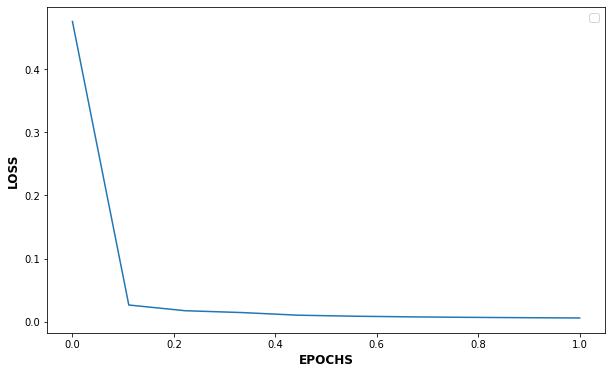

In [0]:
#Plot the Loss function
ax = np.linspace(0, len(Errl)/10, len(Errl), endpoint=True)
plt.figure('Loss by Epoch in ANN', figsize=(10,6))
plt.plot(ax,Errl)
plt.ylabel("LOSS", fontsize = 'large',fontweight = 'bold')
plt.xlabel("EPOCHS", fontsize = 'large',fontweight = 'bold')
plt.legend(fontsize = 'large')
plt.show()

Aqui vamos avaliar a performance dessa rede neural treinada, vendo como ela se sai nos dados separados para validação (dados para os quais ela nunca foi treinada).

In [0]:
#Just a new format
np.set_printoptions(formatter={'float':lambda x: '%+01.2f ' % x})

#Evaluate the ANN
for i in range(150-T):

  #Get the validation input
  xv = Xv[i,:]

  #Get the output for this set 
  y = p.forward(xv)

  #Get the expected output
  yv = Yv[i,:]

  #Show the results - Righ side Expected, Left side Predict
  print(y.T, yv)


[[+0.00  +0.02  +0.98 ]] [+0.00  +0.00  +1.00 ]
[[+0.02  +0.98  +0.00 ]] [+0.00  +1.00  +0.00 ]
[[+0.99  +0.01  +0.00 ]] [+1.00  +0.00  +0.00 ]
[[+0.01  +0.99  +0.00 ]] [+0.00  +1.00  +0.00 ]
[[+0.01  +0.99  +0.00 ]] [+0.00  +1.00  +0.00 ]
[[+0.01  +0.99  +0.00 ]] [+0.00  +1.00  +0.00 ]
[[+0.00  +0.02  +0.98 ]] [+0.00  +0.00  +1.00 ]
[[+0.01  +0.99  +0.00 ]] [+0.00  +1.00  +0.00 ]
[[+0.01  +0.99  +0.00 ]] [+0.00  +1.00  +0.00 ]
[[+0.99  +0.01  +0.00 ]] [+1.00  +0.00  +0.00 ]
